
Training with GD optimizer
Epoch 0, Loss: 588.1480090399721
Epoch 100, Loss: 27.719594561287252
Epoch 200, Loss: 27.307243378232112
Epoch 300, Loss: 27.239935271749985
Epoch 400, Loss: 26.80459426655282
Epoch 500, Loss: 26.371877927706155
Test MSE with GD optimizer: 18.598739560203942

Training with MOMENTUM optimizer
Epoch 0, Loss: 588.1480090399721
Epoch 100, Loss: 40.38788268458831
Epoch 200, Loss: 29.594474287423
Epoch 300, Loss: 29.22879222300451
Epoch 400, Loss: 28.964360212504133
Epoch 500, Loss: 28.628305029949672
Test MSE with MOMENTUM optimizer: 18.576467548114522

Training with ADAM optimizer
Epoch 0, Loss: 588.1480090399721
Epoch 100, Loss: 40.07208676183452
Epoch 200, Loss: 29.785561068160625
Epoch 300, Loss: 29.67585174623297
Epoch 400, Loss: 29.61551960771552
Epoch 500, Loss: 29.55182636841208
Test MSE with ADAM optimizer: 19.70591978487762


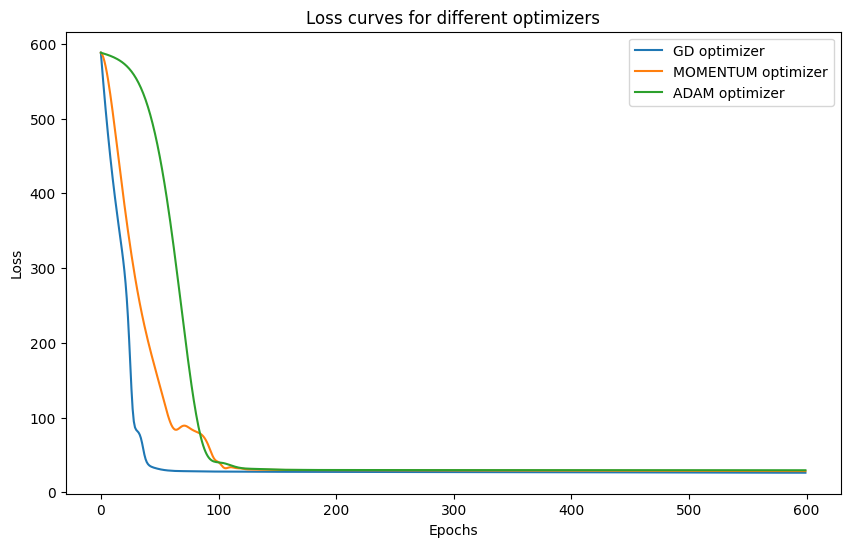

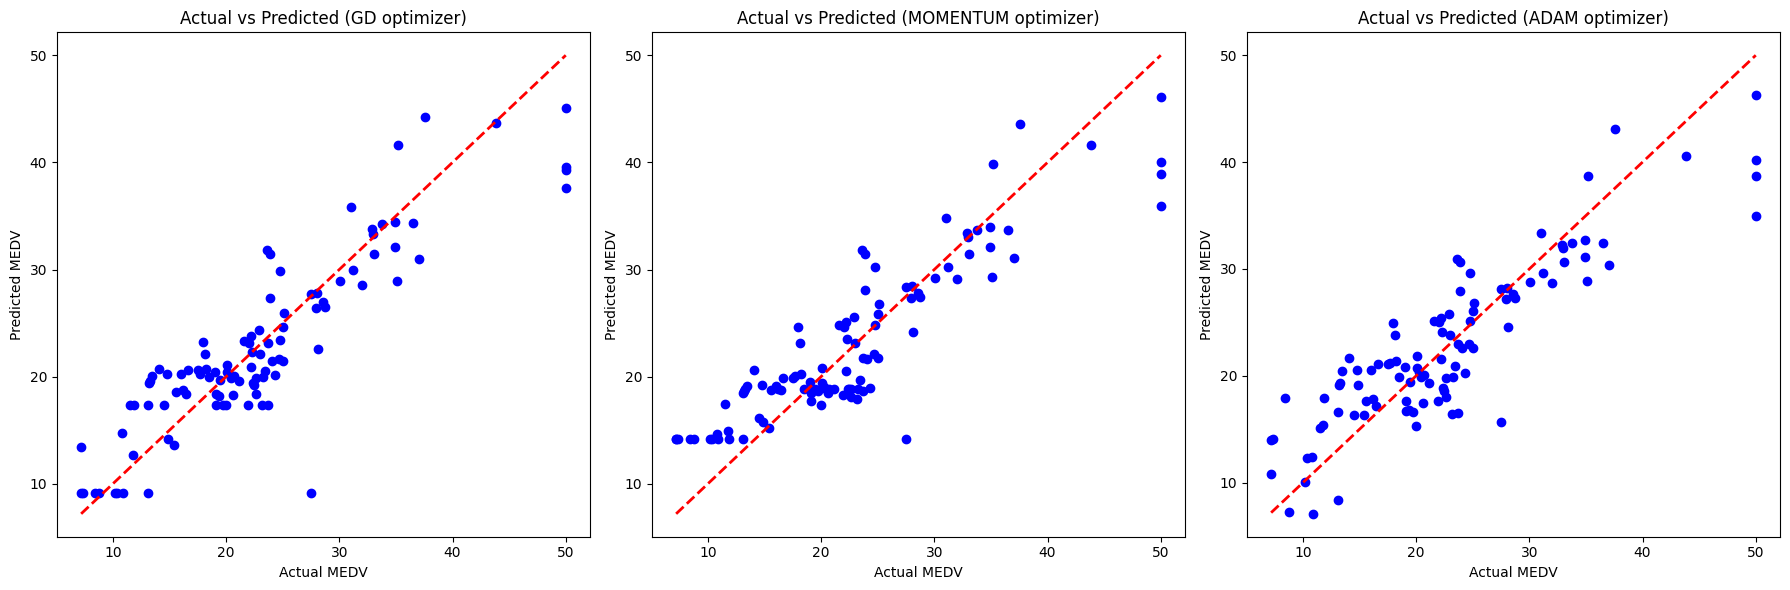

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Load the dataset (assuming it's already loaded as df from the CSV)

df = pd.read_csv('/content/housing.csv', sep='\s+', header=None)
columns = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df.columns=columns

# Extracting features and target
X = df[['RM', 'CRIM']].values
y = df['MEDV'].values.reshape(-1, 1)  # Reshape for compatibility

# Manual feature normalization
X = (X - np.mean(X, axis=0)) / np.std(X, axis=0)   #Doing Normalization to scale the data in [0,1] range. X=(X-mean)/SD
                                                   #Calcuating the mean and standard deviation column-wise

# Split dataset manually into 80% training and 20% testing
def train_test_split(X, y, test_size=0.2):
    indices = np.arange(X.shape[0]) #generating the index from 0 to number of rows in X
    np.random.shuffle(indices)
    split_idx = int(X.shape[0] * (1 - test_size))

    X_train, X_test = X[indices[:split_idx]], X[indices[split_idx:]]
    y_train, y_test = y[indices[:split_idx]], y[indices[split_idx:]]

    return X_train, X_test, y_train, y_test


X_train, X_test, y_train, y_test = train_test_split(X, y)

# Define activation functions
def relu(z):
    return np.maximum(0, z)

def relu_derivative(z):
    return z > 0  #Returning boolean value 1 for Z and 0 for 0

def mse_loss(y_true, y_pred):
    return np.mean((y_true - y_pred) ** 2)   #(y-y_cap)^2

# Initialize parameters
def initialize_parameters(input_size, hidden1_size, hidden2_size, output_size):
    np.random.seed(42)
    params = {
        'W1': np.random.randn(input_size, hidden1_size) * 0.01,         #randn is used here we can also use random.rand
        'b1': np.zeros((1, hidden1_size)),
        'W2': np.random.randn(hidden1_size, hidden2_size) * 0.01,
        'b2': np.zeros((1, hidden2_size)),
        'W3': np.random.randn(hidden2_size, output_size) * 0.01,
        'b3': np.zeros((1, output_size))
    }
    return params

# Forward propagation
def forward_propagation(X, params):
    Z1 = np.dot(X, params['W1']) + params['b1']
    A1 = relu(Z1)

    Z2 = np.dot(A1, params['W2']) + params['b2']
    A2 = relu(Z2)

    Z3 = np.dot(A2, params['W3']) + params['b3']

    return Z3, (Z1, A1, Z2, A2)

# Basic Gradient Descent Optimizer
def gradient_descent(X, y, params, activations, learning_rate=0.02):
    Z1, A1, Z2, A2 = activations
    m = X.shape[0]
    y = y.reshape(-1, 1)

    dZ3 = 2 * (forward_propagation(X, params)[0] - y) / m
    dW3 = np.dot(A2.T, dZ3)
    db3 = np.sum(dZ3, axis=0, keepdims=True)

    dA2 = np.dot(dZ3, params['W3'].T)
    dZ2 = dA2 * relu_derivative(A2)
    dW2 = np.dot(A1.T, dZ2)
    db2 = np.sum(dZ2, axis=0, keepdims=True)

    dA1 = np.dot(dZ2, params['W2'].T)
    dZ1 = dA1 * relu_derivative(A1)
    dW1 = np.dot(X.T, dZ1)
    db1 = np.sum(dZ1, axis=0, keepdims=True)

    params['W1'] -= learning_rate * dW1
    params['b1'] -= learning_rate * db1
    params['W2'] -= learning_rate * dW2
    params['b2'] -= learning_rate * db2
    params['W3'] -= learning_rate * dW3
    params['b3'] -= learning_rate * db3

    return params

# Momentum Optimizer
def momentum_optimizer(X, y, params, activations, learning_rate=0.02, beta=0.9, velocity=None):
    Z1, A1, Z2, A2 = activations
    m = X.shape[0]
    y = y.reshape(-1, 1)

    dZ3 = 2 * (forward_propagation(X, params)[0] - y) / m
    dW3 = np.dot(A2.T, dZ3)
    db3 = np.sum(dZ3, axis=0, keepdims=True)

    dA2 = np.dot(dZ3, params['W3'].T)
    dZ2 = dA2 * relu_derivative(A2)
    dW2 = np.dot(A1.T, dZ2)
    db2 = np.sum(dZ2, axis=0, keepdims=True)

    dA1 = np.dot(dZ2, params['W2'].T)
    dZ1 = dA1 * relu_derivative(A1)
    dW1 = np.dot(X.T, dZ1)
    db1 = np.sum(dZ1, axis=0, keepdims=True)

    if velocity is None:
        velocity = {k: np.zeros_like(v) for k, v in params.items()}

    for param, grad in zip(['W1', 'b1', 'W2', 'b2', 'W3', 'b3'], [dW1, db1, dW2, db2, dW3, db3]):
        velocity[param] = beta * velocity[param] + (1 - beta) * grad
        params[param] -= learning_rate * velocity[param]

    return params, velocity

# Adam Optimizer
def adam_optimizer(X, y, params, activations, learning_rate=0.002, beta1=0.9, beta2=0.999, epsilon=1e-8, t=1, moment=None, velocity=None):
    Z1, A1, Z2, A2 = activations
    m = X.shape[0]
    y = y.reshape(-1, 1)

    dZ3 = 2 * (forward_propagation(X, params)[0] - y) / m
    dW3 = np.dot(A2.T, dZ3)
    db3 = np.sum(dZ3, axis=0, keepdims=True)

    dA2 = np.dot(dZ3, params['W3'].T)
    dZ2 = dA2 * relu_derivative(A2)
    dW2 = np.dot(A1.T, dZ2)
    db2 = np.sum(dZ2, axis=0, keepdims=True)

    dA1 = np.dot(dZ2, params['W2'].T)
    dZ1 = dA1 * relu_derivative(A1)
    dW1 = np.dot(X.T, dZ1)
    db1 = np.sum(dZ1, axis=0, keepdims=True)

    if moment is None or velocity is None:
        moment = {k: np.zeros_like(v) for k, v in params.items()}
        velocity = {k: np.zeros_like(v) for k, v in params.items()}

    for param, grad in zip(['W1', 'b1', 'W2', 'b2', 'W3', 'b3'], [dW1, db1, dW2, db2, dW3, db3]):
        moment[param] = beta1 * moment[param] + (1 - beta1) * grad
        velocity[param] = beta2 * velocity[param] + (1 - beta2) * (grad ** 2)

        moment_corrected = moment[param] / (1 - beta1 ** t)
        velocity_corrected = velocity[param] / (1 - beta2 ** t)

        params[param] -= learning_rate * moment_corrected / (np.sqrt(velocity_corrected) + epsilon)

    return params, moment, velocity

# Train the network
def train_neural_network(X_train, y_train, params, epochs=600, learning_rate=0.02, optimizer='gd'):
    velocity = None
    moment = None
    losses = []

    for epoch in range(epochs):
        y_pred, activations = forward_propagation(X_train, params)
        loss = mse_loss(y_train, y_pred)
        losses.append(loss)

        if optimizer == 'gd':
            params = gradient_descent(X_train, y_train, params, activations, learning_rate)
        elif optimizer == 'momentum':
            params, velocity = momentum_optimizer(X_train, y_train, params, activations, learning_rate, velocity=velocity)
        elif optimizer == 'adam':
            params, moment, velocity = adam_optimizer(X_train, y_train, params, activations, learning_rate, t=epoch + 1, moment=moment, velocity=velocity)

        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss}")

    return params, losses

# Prediction
def predict(X, params):
    y_pred, _ = forward_propagation(X, params)
    return y_pred

# Initialize parameters
params = initialize_parameters(2, 5, 3, 1)

# Train and compare optimizers
optimizers = ['gd', 'momentum', 'adam']
losses_dict = {}
predictions_dict = {}

for opt in optimizers:
    print(f"\nTraining with {opt.upper()} optimizer")
    params_opt = initialize_parameters(2, 5, 3, 1)  # Reinitialize for each optimizer
    params_opt, losses = train_neural_network(X_train, y_train, params_opt, epochs=600, learning_rate=0.01, optimizer=opt)
    losses_dict[opt] = losses

    # Evaluate on test set
    y_pred_test = predict(X_test, params_opt)
    predictions_dict[opt] = y_pred_test
    mse_test = mse_loss(y_test, y_pred_test)
    print(f"Test MSE with {opt.upper()} optimizer: {mse_test}")

# Plot losses for different optimizers
plt.figure(figsize=(10, 6))
for opt, losses in losses_dict.items():
    plt.plot(losses, label=f"{opt.upper()} optimizer")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss curves for different optimizers')
plt.legend()
plt.show()

# Plot Actual vs Predicted values for each optimizer
plt.figure(figsize=(18, 6))

for i, opt in enumerate(optimizers):
    plt.subplot(1, 3, i + 1)
    plt.scatter(y_test, predictions_dict[opt], color='blue')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', lw=2)
    plt.xlabel('Actual MEDV')
    plt.ylabel('Predicted MEDV')
    plt.title(f"Actual vs Predicted ({opt.upper()} optimizer)")

plt.tight_layout()
plt.show()
